## Reading generated images
## Sample Overview

Here, we select the first 100 of 454 gerated photographs. The ChatGPT integration is the final cell.

In [ ]:
import io
import cv2
import json
import time
import requests
import numpy as np
from Levenshtein import distance
from matplotlib import pyplot as plt
from random import sample as samp
from IPython.display import clear_output
from lib.util import to_ai_url, setup_plt
from lib.load import index_urls, gen_images
from lib.util import setup_viz_box, draw_viz_box
from lib.truth import to_truth
from lib.ai import gen_results
from lib.stats import to_ious

USE_AWS_AI = True
NUM_READ = 100 # Use -1 for all data

print("testing", "on aws" if (USE_AWS_AI) else "locally")
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams["figure.dpi"] = 40

images = []
sources = index_urls('merged.json', NUM_READ)
NUM_ALL = len(sources)
if (NUM_READ < 0):
    print(f'Loading {NUM_ALL} images...')
else:
    print(f'Loading {min(NUM_READ,NUM_ALL)} images...')
image_gen = gen_images(sources, '/train/generated-text-images/')

for img in image_gen:
    images.append(img)
    if len(images) % 10 == 0:
        clear_output(wait=True)
        print(round(100*len(images)/len(sources)),'%')

print('Loaded', len(images), 'images!')

## OCR

In [6]:
try: images
except NameError:
    raise(Exception("Please run prior cell"))
try: USE_AWS_AI
except NameError:
    raise(Exception("Please run first cell"))

results = []
for res in gen_results(USE_AWS_AI, images):
    results.append(res)
    clear_output(wait=True)
    print(round(100*len(results)/len(images)),'%')

100 %
Done with classifier and OCR!


## Visualization

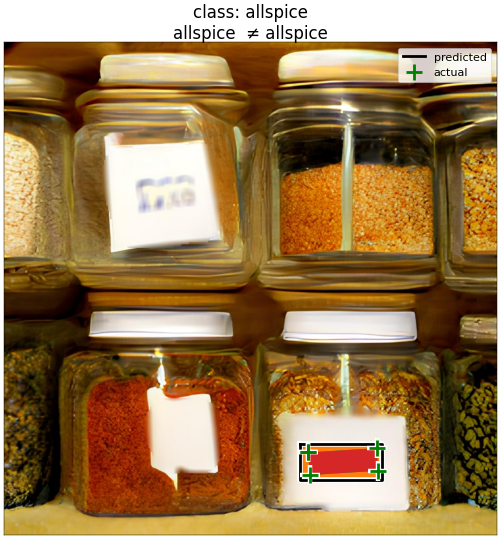

DONE


In [7]:
try: sources and images and results
except NameError:
    raise(Exception("Please run prior cells"))

DELAY_VIZ = 0.01
N_VIZ = 2 #len(sources)

truth = to_truth(sources)
samples = list(zip(truth, images, results))
print(f'sample size: {len(samples)}')
time.sleep(3)
for (i, (real, img, res)) in list(enumerate(samples)):
    res_match = res["prediction"]
    res_lines = [r["text"] for r  in res["ocr_all_results"]]
    res_box = [r["box"] for r  in res["ocr_all_results"]]
    rea_text = real["text"]
    rea_box = real["box"]
    if (i >= N_VIZ): continue
    time.sleep(DELAY_VIZ)
    setup_plt()
    clear_output(wait=True)
    plt.imshow(img)

    # Title to viz box plot
    viz_setup = setup_viz_box(res_match, [*res_lines, ' '], rea_text)

    # Draw predicted and actual bounding boxes
    draw_viz_box('predicted', res_box, viz_setup["predicted"])
    draw_viz_box('actual', rea_box, viz_setup["actual"])
        
    plt.legend(fontsize = 20)
    plt.show()
print('DONE')


# Evaluation (all)

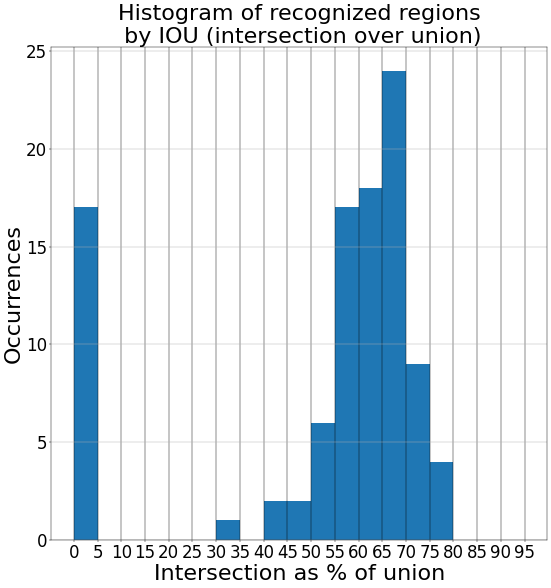

51.71% mean IOU
   62.667% for true predictions

81.0% text accuracy


# Evaluation (correct OCR)

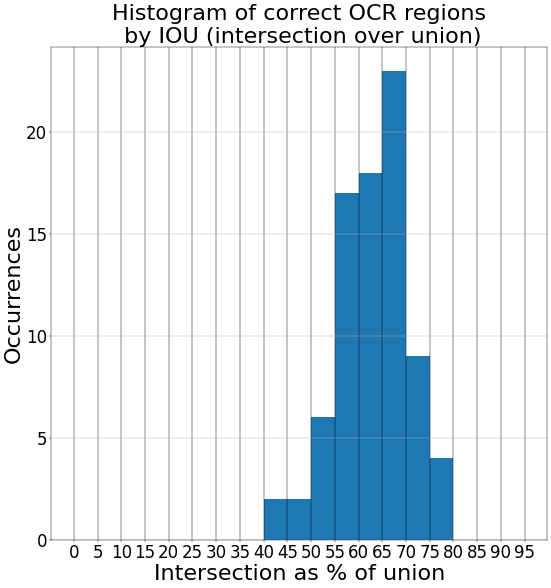

62.667% mean IOU
   62.667% for true predictions

100.0% text accuracy


In [9]:
try: images and truth and results
except NameError:
    raise(Exception("Please run prior cells"))

def sort_by_confidence(res):
    ocr_confident = sorted(res["ocr_all_results"], key=lambda r: ["score"], reverse=True)
    return {**res, "ocr_all_results": [ocr_confident[0]]}

def filter_by_ocr_truth(rea, res):
    if (len(res["ocr_all_results"]) == 0): return False
    lev = distance(rea["text"], res["ocr_all_results"][0]["text"])
    # Levenshtein distance
    return lev <= 3
    
f_r = [sort_by_confidence(r) for r in results]
f = [v for v in zip(images, truth, f_r) if filter_by_ocr_truth(v[1], v[2])]
filtered_img = [v[0] for v in f]
filtered_rea = [v[1] for v in f]
filtered_res = [v[2] for v in f]

word_ious = to_ious(filtered_img, filtered_rea, filtered_res)
setup_plt(True)
bin_range = list(range(0,100,5))
plt.gca().xaxis.grid(True, color='k')
plt.gca().yaxis.grid(True)
plt.hist(word_ious, bins = bin_range, density = False)
plt.title(f'Histogram of correct OCR regions\n by IOU (intersection over union)', fontsize = 40)
plt.tick_params(axis='both', which='major', labelsize = 30)
plt.xticks(bin_range, [f'{x}' for x in bin_range])

plt.xticks(bin_range)
plt.xlabel("Intersection as % of union", fontsize=40)
plt.ylabel("Occurrences", fontsize=40)
plt.show() # TODO

MEAN_IOU = np.mean(word_ious)

TEXT_EQUALITY = [filter_by_ocr_truth(a, b) <= 3 for (_, a, b) in f]
TEXT_ACCURACY = int(np.array(TEXT_EQUALITY, dtype=bool).sum())/len(TEXT_EQUALITY)
MEAN_CORRECT_IOU = np.mean(np.array(word_ious)[TEXT_EQUALITY])

print(f'{round(MEAN_IOU, 3)}% mean IOU')
print(f'   {round(MEAN_CORRECT_IOU, 3)}% for true predictions')
print(f'\n{round(TEXT_ACCURACY*100, 3)}% text accuracy')

# Evaluation (correct Classification)

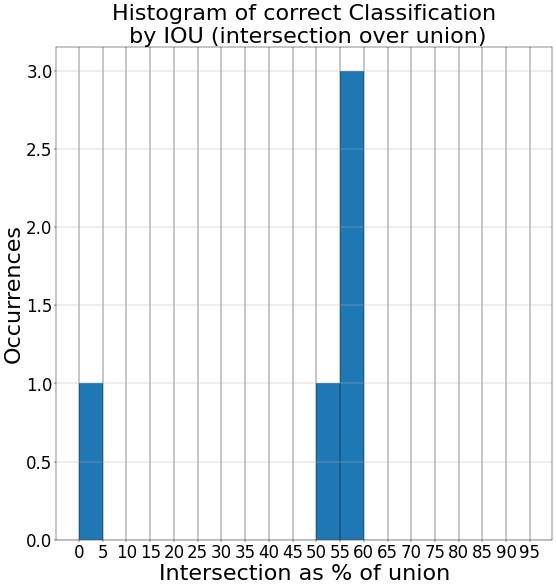

45.4% mean IOU
   45.4% for true predictions

100.0% text accuracy


In [15]:
try: images and truth and results
except NameError:
    raise(Exception("Please run prior cells"))

def sort_by_confidence(res):
    ocr_confident = sorted(res["ocr_all_results"], key=lambda r: ["score"], reverse=True)
    return {**res, "ocr_all_results": [ocr_confident[0]]}

def filter_by_class_truth(rea, res):
    if (len(res["ocr_all_results"]) == 0): return False
    lev = distance(rea["text"], res["prediction"])
    # Levenshtein distance
    return lev <= 3
    
f_r = [sort_by_confidence(r) for r in results]
f = [v for v in zip(images, truth, f_r) if filter_by_class_truth(v[1], v[2])]
filtered_img = [v[0] for v in f]
filtered_rea = [v[1] for v in f]
filtered_res = [v[2] for v in f]

word_ious = to_ious(filtered_img, filtered_rea, filtered_res)
setup_plt(True)
bin_range = list(range(0,100,5))
plt.gca().xaxis.grid(True, color='k')
plt.gca().yaxis.grid(True)
plt.hist(word_ious, bins = bin_range, density = False)
plt.title(f'Histogram of correct Classification\n by IOU (intersection over union)', fontsize = 40)
plt.tick_params(axis='both', which='major', labelsize = 30)
plt.xticks(bin_range, [f'{x}' for x in bin_range])

plt.xticks(bin_range)
plt.xlabel("Intersection as % of union", fontsize=40)
plt.ylabel("Occurrences", fontsize=40)
plt.show() # TODO

MEAN_IOU = np.mean(word_ious)

TEXT_EQUALITY = [filter_by_class_truth(a, b) <= 3 for (_, a, b) in f]
TEXT_ACCURACY = int(np.array(TEXT_EQUALITY, dtype=bool).sum())/len(TEXT_EQUALITY)
MEAN_CORRECT_IOU = np.mean(np.array(word_ious)[TEXT_EQUALITY])

print(f'{round(MEAN_IOU, 3)}% mean IOU')
print(f'   {round(MEAN_CORRECT_IOU, 3)}% for true predictions')
print(f'\n{round(TEXT_ACCURACY*100, 3)}% text accuracy')

# Evaluation (all)


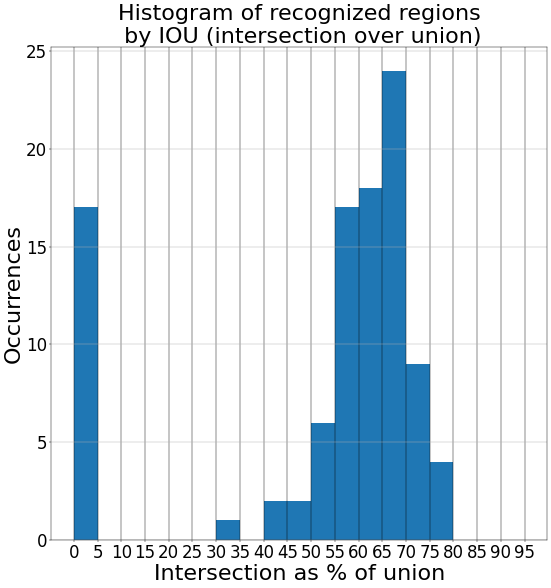

51.71% mean IOU
   62.667% for true predictions

81.0% text accuracy


In [16]:
try: images and truth and results
except NameError:
    raise(Exception("Please run prior cells"))

def filter_by_confidence(res):
    ocr_confident = sorted(res["ocr_all_results"], key=lambda r: ["score"], reverse=True)
    return {**res, "ocr_all_results": [ocr_confident[0]]}

def filter_by_ocr_truth(rea, res):
    if (len(res["ocr_all_results"]) == 0): return False
    lev = distance(rea["text"], res["ocr_all_results"][0]["text"])
    # Levenshtein distance
    return lev <= 3

f_r = [filter_by_confidence(r) for r in results]
f = [v for v in zip(images, truth, f_r) if len(v[2]['ocr_all_results'])]
filtered_img = [v[0] for v in f]
filtered_rea = [v[1] for v in f]
filtered_res = [v[2] for v in f]

word_ious = to_ious(filtered_img, filtered_rea, filtered_res)
setup_plt(True)
bin_range = list(range(0,100,5))
plt.gca().xaxis.grid(True, color='k')
plt.gca().yaxis.grid(True)
plt.hist(word_ious, bins = bin_range, density = False)
plt.title(f'Histogram of recognized regions\n by IOU (intersection over union)', fontsize = 40)
plt.tick_params(axis='both', which='major', labelsize = 30)
plt.xticks(bin_range, [f'{x}' for x in bin_range])

plt.xticks(bin_range)
plt.xlabel("Intersection as % of union", fontsize=40)
plt.ylabel("Occurrences", fontsize=40)
plt.show() # TODO

MEAN_IOU = np.mean(word_ious)

TEXT_EQUALITY = [filter_by_ocr_truth(a, b) for (_, a, b) in f]
TEXT_ACCURACY = int(np.array(TEXT_EQUALITY, dtype=bool).sum())/len(TEXT_EQUALITY)
MEAN_CORRECT_IOU = np.mean(np.array(word_ious)[TEXT_EQUALITY])

print(f'{round(MEAN_IOU, 3)}% mean IOU')
print(f'   {round(MEAN_CORRECT_IOU, 3)}% for true predictions')
print(f'\n{round(TEXT_ACCURACY*100, 3)}% text accuracy')

## Recipe generation

In [14]:
N_GPT = 5
DELAY_GPT = 5.0

ai_server_url = to_ai_url(USE_AWS_AI)
print(f'Using Custom AI: {ai_server_url}')

#api request instructions
def chat_with_gpt(spices):
    endpoint = f'{ai_server_url}recipe'
    response = requests.post(endpoint, json.dumps({
        "spices": spices
    }))
    res_data = response.json()
    return res_data
  
found_spices = set([v['prediction'] for (t,v) in zip(TEXT_EQUALITY, results) if t])
spice_lists = [samp(list(found_spices),samp([2,3,4],1)[0]) for _ in range(N_GPT)]

for spices in spice_lists:
    clear_output(wait=True)
    print('INPUT SPICES:')
    print('-', ', '.join(spices))
    output = chat_with_gpt(spices)
    print('\nOUTPUT RECIPE:')
    print(f'{len(output["spices"]) - len(spices)} added spices')
    print(f'{len(output["ingredients"])} added ingredients')
    print()
    print(output["text"])
    time.sleep(DELAY_GPT)
    print('\n')

INPUT SPICES:
- cinnamon, celery_seed, nutmeg, cumin

OUTPUT RECIPE:
0 added spices
7 added ingredients

Title: Cinnamon and Celery Seed Roasted Vegetables
Spices: cinnamon, celery_seed, nutmeg, cumin
Ingredients: 2 tablespoons olive oil, 2 teaspoons ground cinnamon, 1 teaspoon celery seed, 1 teaspoon ground nutmeg, 1 teaspoon ground cumin, 1/4 teaspoon salt, 4 cups of mixed vegetables (such as potatoes, carrots, onions, and peppers)


